# Implementación de GEEMAP
**Motivación: Porque es un desarrollo muy sencillo y tiene mas tutoriales que videos de como hacer un pan de masa madre**

Source: https://geemap.org/

Haremos un par de ejercitaciones: 

[1] Descargar una imágen satelital (por ej: Landsat)

[2] Descargar un grupo de imágenes satelitales (por ej:Landsat)

[3] Incorporar proyectos de evluación de cuerpos de agua

[4] Hacer un timelapsed

[5] Extraer datos de las imagenes como superficie de agua con indicadores

In [13]:
#!pip install geemap

In [1]:
import ee
import geemap
from geemap.algorithms import river

In [15]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

Generamos un punto de control

In [16]:
point = ee.Geometry.Point([-64.264511, -27.764386])#Santiago del Estero

Filtramos la imagen que necesitamos

In [17]:
#agregamos al mapa de trabajo
Map.addLayer(image, {'min': 0, 'max': 3000, 'bands': ['B5', 'B4', 'B3']}, "Landsat")
Map.centerObject(image)

In [18]:
#MASCARA de AGUA
water_mask1 = ee.ImageCollection("projects/sat-io/open-datasets/OSM_waterLayer").median()
Map.addLayer(water_mask1, {'min': 11, 'max': 125, 'palette': 'ocean'}, 'OSM_WATER')

Proyecto [Global River Width Dataset](https://samapriya.github.io/awesome-gee-community-datasets/projects/grwl)

In [18]:
## OTRA MASCARA
water_mask = ee.ImageCollection(
    "projects/sat-io/open-datasets/GRWL/water_mask_v01_01"
).median()
Map.addLayer(water_mask, {'min': 11, 'max': 125, 'palette': 'blue'}, 'GRWL Water Mask')

## Descarga de colección de imágenes ee.ImageCollection

In [2]:
import os

In [3]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [4]:
image = ee.Image('LANDSAT/LE7_TOA_5YEAR/1999_2003')

landsat_vis = {'bands': ['B4', 'B3', 'B2'], 'gamma': 1.4}
Map.addLayer(image, landsat_vis, "LE7_TOA_5YEAR/1999_2003", True, 0.7)

In [5]:
feature = Map.draw_last_feature
roi = feature.geometry()

In [6]:
out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
filename = os.path.join(out_dir, 'landsat.tif')

### Exporta todas las bandas como una imagen

In [7]:
image = image.clip(roi).unmask()
geemap.ee_export_image(
    image, filename=filename, scale=90, region=roi, file_per_band=False
)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\LGDR\Downloads\landsat.tif


In [13]:
Map.addLayer(image)

### Exporta cada banda

In [12]:
geemap.ee_export_image(
    image, filename=filename, scale=90, region=roi, file_per_band=True
)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\LGDR\Downloads


## Calculate NDWI

The Normalized Difference Water Index (NDWI) is used to monitor changes related to water content in water bodies, using green and NIR wavelengths, defined by McFeeters (1996):

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/fd21ea077007b78b7bf753498d4953991837cb26)

## Extract water

## Apply the algorithm to all images

In [8]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

Define input parameters

In [9]:
feature = Map.draw_last_feature
roi = feature.geometry()
start_date = '2015-01-01'
end_date = '2019-12-31'
cloud_threshold = 0.05
ndwi_threshold = 0

In [10]:
images = (
    ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')
    .filterBounds(roi)
    .filterDate(start_date, end_date)
    .filterMetadata('CLOUD_COVER', 'less_than', cloud_threshold)
)

In [11]:
print(images.size().getInfo())

8


In [12]:
print(images.aggregate_array('system:id').getInfo())

['LANDSAT/LC08/C01/T1_SR/LC08_230079_20150208', 'LANDSAT/LC08/C01/T1_SR/LC08_230079_20170128', 'LANDSAT/LC08/C01/T1_SR/LC08_230079_20171112', 'LANDSAT/LC08/C01/T1_SR/LC08_230079_20171230', 'LANDSAT/LC08/C01/T1_SR/LC08_230079_20180405', 'LANDSAT/LC08/C01/T1_SR/LC08_230079_20181115', 'LANDSAT/LC08/C01/T1_SR/LC08_230079_20190219', 'LANDSAT/LC08/C01/T1_SR/LC08_230079_20190408']


In [13]:
dates = images.aggregate_array('system:time_start').map(
    lambda d: ee.Date(d).format('YYYY-MM-dd')
)
print(dates.getInfo())

['2015-02-08', '2017-01-28', '2017-11-12', '2017-12-30', '2018-04-05', '2018-11-15', '2019-02-19', '2019-04-08']


In [14]:
first_image = ee.Image(images.toList(images.size()).get(3))
vis_params = {
    'bands': ['B5', 'B4', 'B3'],
    'min': 0,
    'max': 6000,
    'gamma': 1.4,
}
Map.addLayer(first_image, vis_params, 'First image')
Map.centerObject(roi, 8)

In [15]:
def extract_water(img):

    ndwi_image = img.normalizedDifference(['B3', 'B5'])
    water_image = ndwi_image.gt(ndwi_threshold)
    return water_image

In [16]:
ndwi_images = images.map(extract_water)

In [17]:
first_ndwi_image = ee.Image(ndwi_images.toList(ndwi_images.size()).get(0)).selfMask()
Map.addLayer(first_ndwi_image, {'palette': 'Blues'}, 'First NDWI')

In [18]:
occurrence = ndwi_images.sum().selfMask()
Map.addLayer(occurrence.randomVisualizer(), {}, 'Water occurrence')

In [19]:
def ras_to_vec(img):
    vec = img.selfMask().reduceToVectors(scale=30, maxPixels=60000000)
    vec = vec.filterBounds(roi)
    return vec.set({'area': vec.geometry().area(1).divide(1e6).round()})

In [20]:
ndwi_vectors = ndwi_images.map(ras_to_vec)

In [21]:
areas = ndwi_vectors.aggregate_array('area')
print(areas.getInfo())

[168, 198, 193, 111, 202, 204, 231, 217]


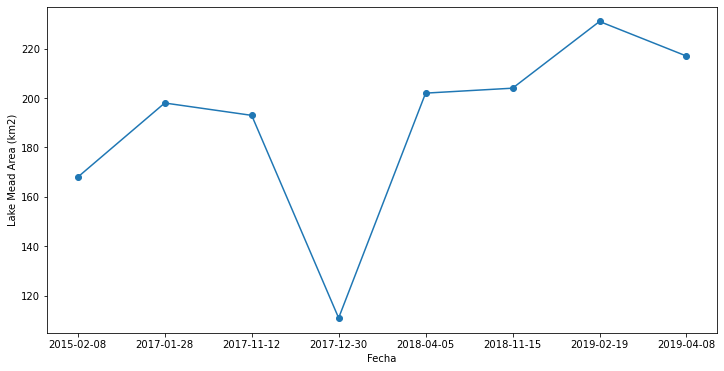

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(12, 6))

x = dates.getInfo()
y = areas.getInfo()

plt.plot(x, y, marker='o')
plt.xlabel('Fecha')
plt.ylabel('Lake Mead Area (km2)')
plt.show()

## Create Landsat timeseries

In [1]:
import os
import ee
import geemap

In [2]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [14]:
roi = Map.draw_last_feature

In [15]:
collection = geemap.landsat_timeseries(
    roi=roi, start_year=1985, end_year=2020, start_date='06-10', end_date='09-20'
)

In [16]:
print(collection.size().getInfo())

36


In [17]:
first_image = collection.first()

vis = {'bands': ['NIR', 'Red', 'Green'], 'min': 0, 'max': 4000, 'gamma': [1, 1, 1]}

Map.addLayer(first_image, vis, 'First image')

## Download ImageCollection as a GIF

In [18]:
# Define arguments for animation function parameters.
video_args = {
    'dimensions': 768,
    'region': roi,
    'framesPerSecond': 10,
    'bands': ['NIR', 'Red', 'Green'],
    'min': 0,
    'max': 4000,
    'gamma': [1, 1, 1],
}

In [19]:
work_dir = os.path.join(os.path.expanduser("~"), 'Downloads')
if not os.path.exists(work_dir):
    os.makedirs(work_dir)
out_gif = os.path.join(work_dir, "landsat_ts.gif")

In [20]:
geemap.download_ee_video(collection, video_args, out_gif)

Generating URL...
Please wait ...
The GIF image has been saved to: C:\Users\LGDR\Downloads\landsat_ts.gif


## Add animated text to GIF

In [10]:
geemap.show_image(out_gif)

Output()

In [11]:
texted_gif = os.path.join(work_dir, "landsat_ts_text.gif")
geemap.add_text_to_gif(
    out_gif,
    texted_gif,
    xy=('3%', '5%'),
    text_sequence=1985,
    font_size=30,
    font_color='#ffffff',
    add_progress_bar=False,
)

In [12]:
label = 'Urban Growth in Las Vegas'
geemap.add_text_to_gif(
    texted_gif,
    texted_gif,
    xy=('2%', '88%'),
    text_sequence=label,
    font_size=30,
    font_color='#ffffff',
    progress_bar_color='cyan',
)

In [13]:
geemap.show_image(texted_gif)

Output()